# GAN Trainer

Takes the gan model and trains it to produce optimal weights to be loaded in

## Load in the data

In [2]:
import numpy as np
from multiprocessing import cpu_count
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import time
from PIL import Image
sys.path.append("super-resolution-model-tests")
from dataloader import DIV2KDataLoader

# For GPU (CUDA) or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load and preprocess the dataset
transformList = []
transformList.append(transforms.ToTensor())
basic_transforms = transforms.Compose(transformList)

datasetRoot = "super-resolution-model-tests/DIV2K"
lr_path = datasetRoot+"/DIV2K_train_LR_x8"
hr_path = datasetRoot+"/DIV2K_train_HR"

train_dataset = DIV2KDataLoader(
    root_dir_lr=lr_path,
    root_dir_hr=hr_path,
    transform=basic_transforms,
    mode="train",
    batch_size=16,
    scale=4
)

lr_path = datasetRoot+"/DIV2K_valid_LR_x8"
hr_path = datasetRoot+"/DIV2K_valid_HR"

val_dataset = DIV2KDataLoader(
    root_dir_lr=lr_path,
    root_dir_hr=hr_path,
    transform=basic_transforms,
    mode="val",
    batch_size=16,
    scale=4
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=8,
    pin_memory=True,
    num_workers=cpu_count(),
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=8,
    num_workers=cpu_count(),
    pin_memory=True,
)

ModuleNotFoundError: No module named 'matplotlib'

## Train Generator and Discriminator

In [2]:

from gan import Generator, Discriminator

# Define the Binary Cross Entropy loss function
loss_func = nn.BCEWithLogitsLoss()

def discriminator_loss(real_output, fake_output):
    # Loss for real images
    real_loss = loss_func(real_output, torch.ones_like(real_output).to(device))
    # Loss for fake images
    fake_loss = loss_func(fake_output, torch.zeros_like(fake_output).to(device))

    loss_D = real_loss + fake_loss
    return loss_D

def generator_loss(fake_output):
    # Compare discriminator's output on fake images with target labels of 1
    loss_G = loss_func(fake_output, torch.ones_like(fake_output).to(device))
    return loss_G

In [3]:

from utils.save_checkpoint import save_checkpoint

def training(lr_img, hr_img):

    '''Training step for the Discriminator'''
    real_x = hr_img.to(device)
    real_output = gan_D(real_x)
    fake_x = gan_G(lr_img.to(device)).detach()
    fake_output = gan_D(fake_x)
    loss_D =discriminator_loss(real_output, fake_output)

    # Backpropagate the discriminator loss and update its parameters
    optim_D.zero_grad()
    loss_D.backward()
    optim_D.step()

    '''Training step for the Generator'''
    fake_x = gan_G(lr_img.to(device))
    fake_output = gan_D(fake_x)
    loss_G = generator_loss(fake_output)

    # Backpropagate the generator loss and update its parameters
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()

    return loss_D, loss_G

In [47]:
import torchvision.transforms.functional as TF

def visualise_generated_images(generator, epoch, image_dir, num_samples=1):
    generator.eval()

    for i in range(num_samples):
        # --- Pick a sample ---
        lr_img, hr_img = train_dataset[i]
        lr_img = lr_img.unsqueeze(0).to(device)
        hr_img = hr_img.unsqueeze(0).to(device)

        # --- Generate SR image ---
        with torch.no_grad():
            sr_img = generator(lr_img)


        # --- Resize HR and LR to match SR size for visualization ---
        sr_h, sr_w = sr_img.shape[2], sr_img.shape[3]
        lr_resized = F.interpolate(lr_img, size=(sr_h, sr_w), mode='bilinear', align_corners=False)
        hr_resized = F.interpolate(hr_img, size=(sr_h, sr_w), mode='bilinear', align_corners=False)


        # --- Make comparison grid ---
        comparison = torch.cat([lr_resized, sr_img, hr_resized], dim=0)
        grid = torchvision.utils.make_grid(comparison, nrow=3, normalize=True)
        grid_np = grid.permute(1, 2, 0).cpu().numpy()
        grid_uint8 = (grid_np * 255).astype(np.uint8)

        # --- Save ---
        filename = f"{image_dir}/epoch_{epoch}_sample_{i}.png"
        Image.fromarray(grid_uint8).save(filename)

        # --- Display ---
        plt.imshow(grid_np)
        plt.axis("off")
        plt.show()

    generator.train()

def visualise_loss(losses_D, losses_G, image_dir, loss_type):
  plt.plot(losses_D, label="losses_D")
  plt.plot(losses_G, label="losses_G")
  plt.title(loss_type)
  plt.legend()
  plt.savefig(f"./{image_dir}/loss_type: {loss_type}.png")
  plt.show()

Epoch [1/50] | Loss_D 1.4550 | Loss_G 14.1611 | Time: 4.90 sec
Epoch [1/50]  | Loss_D 1.4507 | Loss_G 14.1130 | Time: 4.90 sec


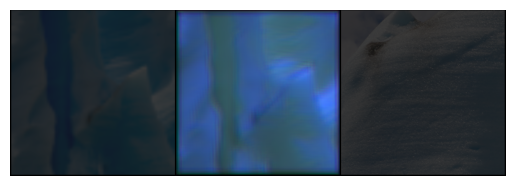

Epoch [2/50] | Loss_D 0.6581 | Loss_G 17.0607 | Time: 5.09 sec
Epoch [2/50]  | Loss_D 0.8082 | Loss_G 11.0165 | Time: 5.09 sec


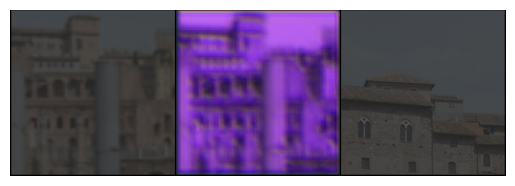

Epoch [3/50] | Loss_D 3.9411 | Loss_G 16.7507 | Time: 5.12 sec
Epoch [3/50]  | Loss_D 2.1472 | Loss_G 17.0777 | Time: 5.12 sec


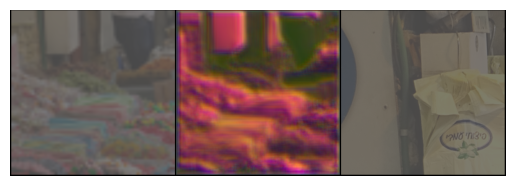

Epoch [4/50] | Loss_D 1.1707 | Loss_G 22.4648 | Time: 5.21 sec
Epoch [4/50]  | Loss_D 1.3490 | Loss_G 20.9590 | Time: 5.21 sec


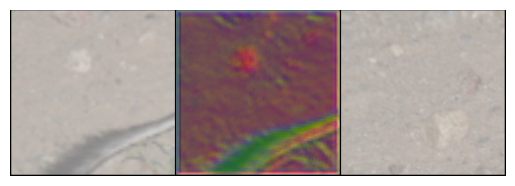

Epoch [5/50] | Loss_D 0.2507 | Loss_G 16.1719 | Time: 5.41 sec
Epoch [5/50]  | Loss_D 0.2504 | Loss_G 19.8309 | Time: 5.41 sec


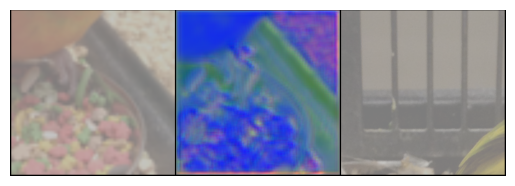

Epoch [6/50] | Loss_D 1.9198 | Loss_G 22.6108 | Time: 5.22 sec
Epoch [6/50]  | Loss_D 2.6380 | Loss_G 20.4430 | Time: 5.23 sec


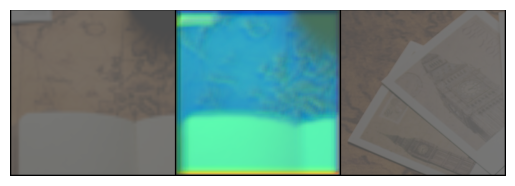

Epoch [7/50] | Loss_D 2.7229 | Loss_G 25.2727 | Time: 6.11 sec
Epoch [7/50]  | Loss_D 2.7304 | Loss_G 21.2968 | Time: 6.11 sec


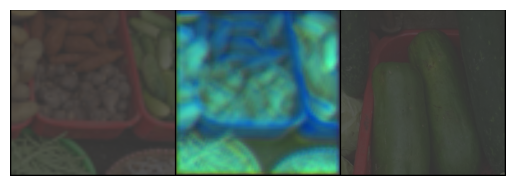

Epoch [8/50] | Loss_D 3.3019 | Loss_G 18.2456 | Time: 5.51 sec
Epoch [8/50]  | Loss_D 4.8061 | Loss_G 22.0754 | Time: 5.51 sec


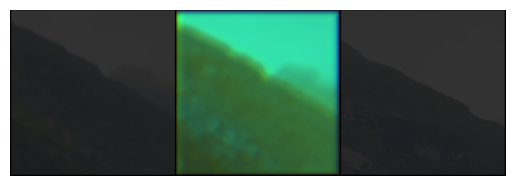

Epoch [9/50] | Loss_D 6.7866 | Loss_G 18.8856 | Time: 5.78 sec
Epoch [9/50]  | Loss_D 3.3961 | Loss_G 17.4199 | Time: 5.78 sec


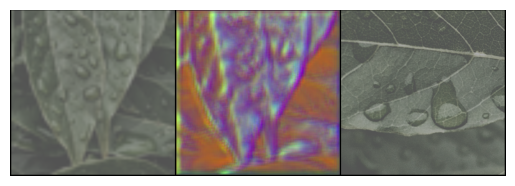

Checkpoint saved for epoch 10
Epoch [10/50] | Loss_D 7.2194 | Loss_G 29.8646 | Time: 11.45 sec
Epoch [10/50]  | Loss_D 7.2262 | Loss_G 22.2727 | Time: 11.45 sec


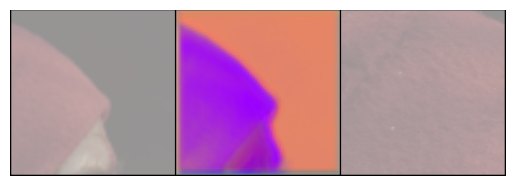

Epoch [11/50] | Loss_D 0.0275 | Loss_G 26.3019 | Time: 5.15 sec
Epoch [11/50]  | Loss_D 0.7087 | Loss_G 28.4915 | Time: 5.15 sec


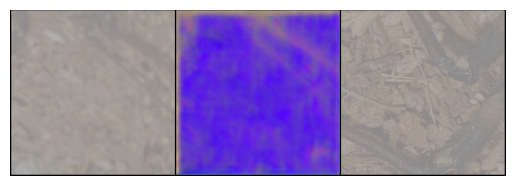

Epoch [12/50] | Loss_D 0.5506 | Loss_G 26.7403 | Time: 5.09 sec
Epoch [12/50]  | Loss_D 3.0359 | Loss_G 26.4238 | Time: 5.09 sec


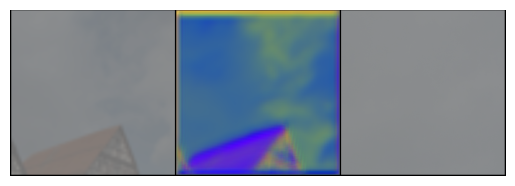

Epoch [13/50] | Loss_D 5.2588 | Loss_G 7.1570 | Time: 5.07 sec
Epoch [13/50]  | Loss_D 2.8456 | Loss_G 12.5038 | Time: 5.07 sec


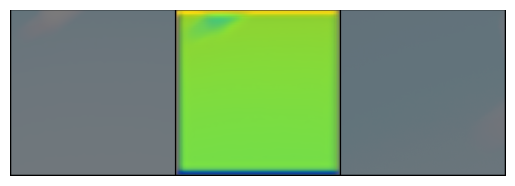

Epoch [14/50] | Loss_D 3.5789 | Loss_G 15.4127 | Time: 5.06 sec
Epoch [14/50]  | Loss_D 3.7114 | Loss_G 15.7386 | Time: 5.06 sec


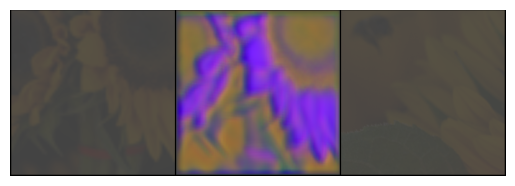

Epoch [15/50] | Loss_D 1.7883 | Loss_G 28.9039 | Time: 5.10 sec
Epoch [15/50]  | Loss_D 1.9677 | Loss_G 27.5182 | Time: 5.10 sec


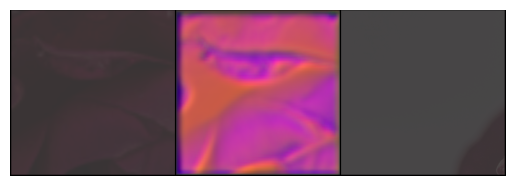

Epoch [16/50] | Loss_D 0.2102 | Loss_G 17.7293 | Time: 5.25 sec
Epoch [16/50]  | Loss_D 0.4873 | Loss_G 25.4257 | Time: 5.25 sec


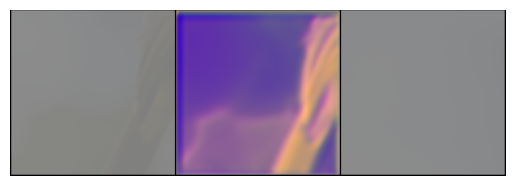

Epoch [17/50] | Loss_D 3.9972 | Loss_G 9.6392 | Time: 5.66 sec
Epoch [17/50]  | Loss_D 3.0680 | Loss_G 10.6150 | Time: 5.66 sec


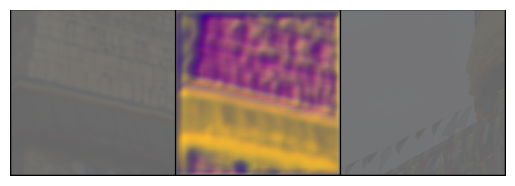

Epoch [18/50] | Loss_D 0.3979 | Loss_G 21.1163 | Time: 5.22 sec
Epoch [18/50]  | Loss_D 1.2949 | Loss_G 18.9859 | Time: 5.22 sec


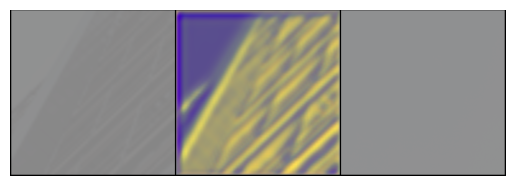

Epoch [19/50] | Loss_D 0.7014 | Loss_G 25.1391 | Time: 5.83 sec
Epoch [19/50]  | Loss_D 0.3655 | Loss_G 22.5908 | Time: 5.83 sec


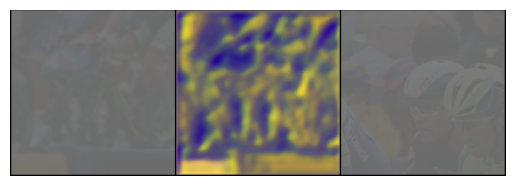

Checkpoint saved for epoch 20
Epoch [20/50] | Loss_D 0.1057 | Loss_G 26.5766 | Time: 6.73 sec
Epoch [20/50]  | Loss_D 0.0562 | Loss_G 28.5897 | Time: 6.73 sec


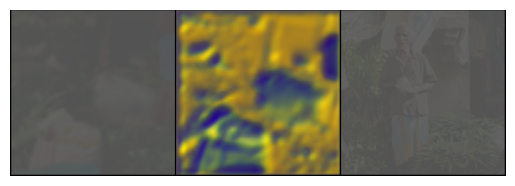

Epoch [21/50] | Loss_D 0.0000 | Loss_G 22.2446 | Time: 5.70 sec
Epoch [21/50]  | Loss_D 0.2797 | Loss_G 23.7274 | Time: 5.70 sec


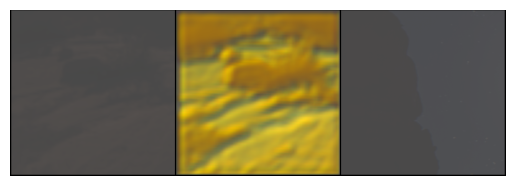

Epoch [22/50] | Loss_D 2.9782 | Loss_G 18.2052 | Time: 5.14 sec
Epoch [22/50]  | Loss_D 1.4972 | Loss_G 16.5754 | Time: 5.14 sec


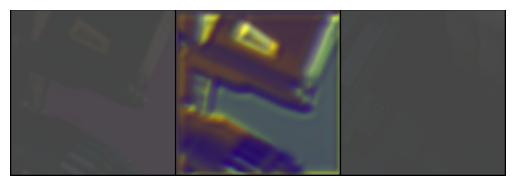

Epoch [23/50] | Loss_D 0.1255 | Loss_G 14.5040 | Time: 5.70 sec
Epoch [23/50]  | Loss_D 0.1718 | Loss_G 14.5081 | Time: 5.70 sec


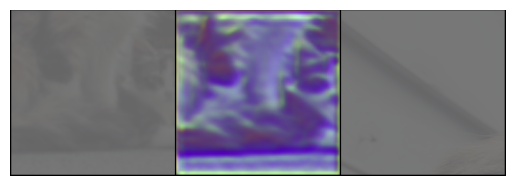

Epoch [24/50] | Loss_D 7.5380 | Loss_G 15.8882 | Time: 5.22 sec
Epoch [24/50]  | Loss_D 4.3348 | Loss_G 13.8070 | Time: 5.22 sec


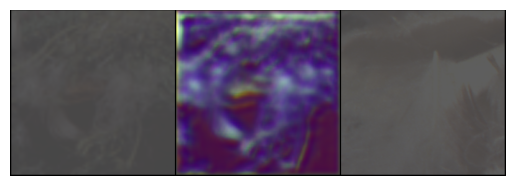

Epoch [25/50] | Loss_D 0.4807 | Loss_G 20.8908 | Time: 5.13 sec
Epoch [25/50]  | Loss_D 0.8927 | Loss_G 16.4102 | Time: 5.13 sec


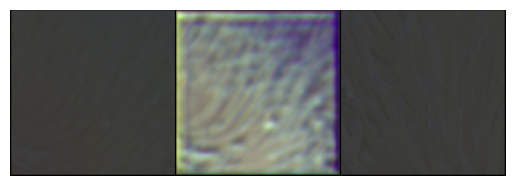

Epoch [26/50] | Loss_D 4.4600 | Loss_G 27.9472 | Time: 5.20 sec
Epoch [26/50]  | Loss_D 2.7598 | Loss_G 27.4195 | Time: 5.20 sec


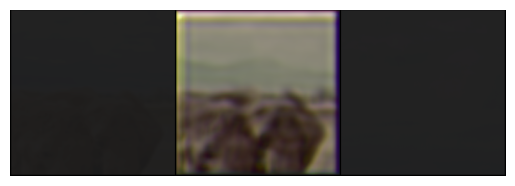

Epoch [27/50] | Loss_D 0.0159 | Loss_G 25.9349 | Time: 5.19 sec
Epoch [27/50]  | Loss_D 0.0684 | Loss_G 29.5869 | Time: 5.19 sec


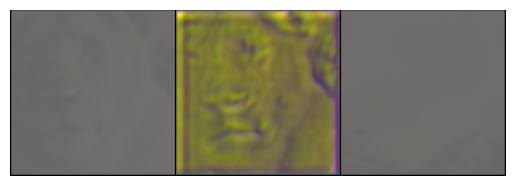

Epoch [28/50] | Loss_D 0.0200 | Loss_G 34.9101 | Time: 5.20 sec
Epoch [28/50]  | Loss_D 0.0113 | Loss_G 31.6000 | Time: 5.20 sec


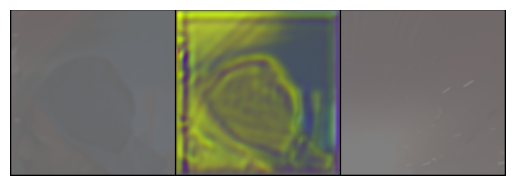

Epoch [29/50] | Loss_D 0.3664 | Loss_G 47.6415 | Time: 5.12 sec
Epoch [29/50]  | Loss_D 1.8454 | Loss_G 51.2165 | Time: 5.12 sec


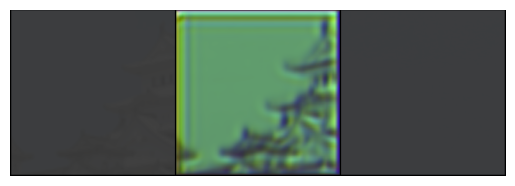

Checkpoint saved for epoch 30
Epoch [30/50] | Loss_D 0.0000 | Loss_G 43.0285 | Time: 6.91 sec
Epoch [30/50]  | Loss_D 0.0417 | Loss_G 41.9112 | Time: 6.91 sec


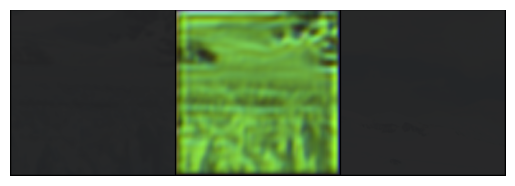

Epoch [31/50] | Loss_D 0.0053 | Loss_G 16.3559 | Time: 5.25 sec
Epoch [31/50]  | Loss_D 0.0031 | Loss_G 22.1057 | Time: 5.25 sec


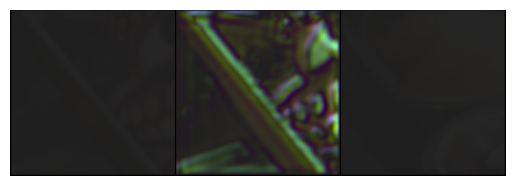

Epoch [32/50] | Loss_D 3.9887 | Loss_G 22.1102 | Time: 5.35 sec
Epoch [32/50]  | Loss_D 2.0234 | Loss_G 16.6302 | Time: 5.35 sec


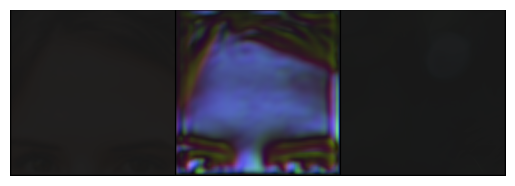

Epoch [33/50] | Loss_D 0.5452 | Loss_G 27.5162 | Time: 5.15 sec
Epoch [33/50]  | Loss_D 0.2954 | Loss_G 30.0736 | Time: 5.15 sec


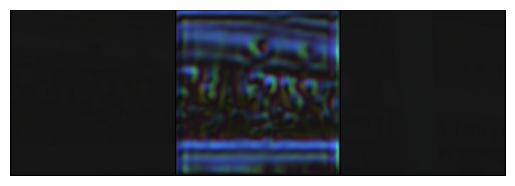

Epoch [34/50] | Loss_D 0.0854 | Loss_G 28.3765 | Time: 6.10 sec
Epoch [34/50]  | Loss_D 2.2614 | Loss_G 27.6113 | Time: 6.10 sec


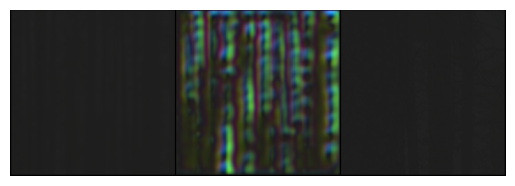

Epoch [35/50] | Loss_D 1.9154 | Loss_G 30.2777 | Time: 5.05 sec
Epoch [35/50]  | Loss_D 1.4059 | Loss_G 26.7162 | Time: 5.05 sec


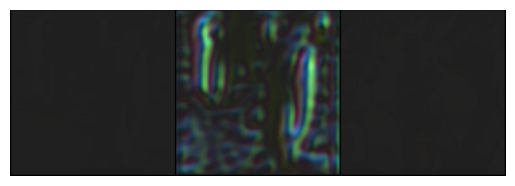

Epoch [36/50] | Loss_D 0.3998 | Loss_G 32.6135 | Time: 5.29 sec
Epoch [36/50]  | Loss_D 0.2165 | Loss_G 28.7833 | Time: 5.29 sec


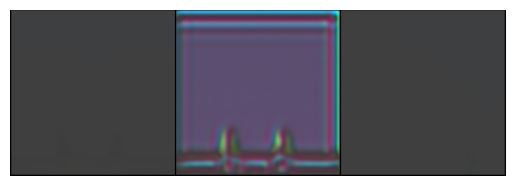

Epoch [37/50] | Loss_D 0.0095 | Loss_G 30.7692 | Time: 5.10 sec
Epoch [37/50]  | Loss_D 0.6597 | Loss_G 32.7292 | Time: 5.10 sec


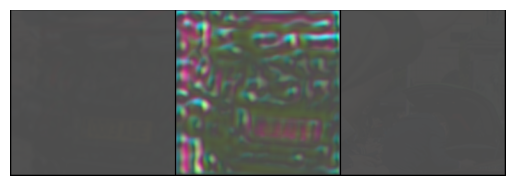

Epoch [38/50] | Loss_D 0.0002 | Loss_G 29.5419 | Time: 5.08 sec
Epoch [38/50]  | Loss_D 0.0002 | Loss_G 33.2489 | Time: 5.08 sec


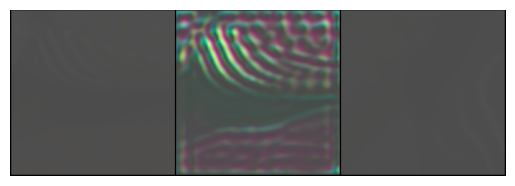

KeyboardInterrupt: 

In [48]:
input_dim = 3
# batch_size = 8
num_epoch = 50
checkpoint_dir = 'super-resolution-model-tests/training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
image_dir = 'super-resolution-model-tests/generated_image/'
os.makedirs(image_dir, exist_ok=True)

gan_G = Generator(input_dim).to(device)
gan_D = Discriminator().to(device)

# Define separate Adam optimizers for generator and discriminator
optim_G = torch.optim.Adam(gan_G.parameters(), lr=0.0002)
optim_D = torch.optim.Adam(gan_D.parameters(), lr=0.0002)

# Initialise the list to store the losses for each epoch
iteration_losses_D = []
iteration_losses_G = []
epoch_losses_D = []
epoch_losses_G = []

for epoch in range(num_epoch):
    start_time = time.time()
    total_loss_D, total_loss_G = 0, 0

    for idx, (lr_img, hr_img) in enumerate(train_loader):
        loss_D, loss_G = training(lr_img, hr_img)

        iteration_losses_D.append(loss_D.detach().item())
        iteration_losses_G.append(loss_G.detach().item())
        total_loss_D += loss_D.detach().item()
        total_loss_G += loss_G.detach().item()

    epoch_losses_D.append(total_loss_D / len(train_loader))
    epoch_losses_G.append(total_loss_G / len(train_loader))

    # Save model checkpoints
    if (epoch + 1) % 10 == 0:
        save_checkpoint(epoch + 1, gan_G, gan_D, optim_G, optim_D, checkpoint_dir)

    # losses once per epoch
    print(f'Epoch [{epoch + 1}/{num_epoch}] | Loss_D {iteration_losses_D[-1]:.4f} | Loss_G {iteration_losses_G[-1]:.4f} | Time: {time.time() - start_time:.2f} sec')
    print(f'Epoch [{epoch + 1}/{num_epoch}]  | Loss_D {epoch_losses_D[epoch]:.4f} | Loss_G {epoch_losses_G[epoch]:.4f} | Time: {time.time() - start_time:.2f} sec')

    # Task1: visualise the generated image at different epochs
    visualise_generated_images(gan_G, epoch, image_dir)

# Task2: visualise the loss through a plot
visualise_loss(iteration_losses_D, iteration_losses_G, image_dir, 'Iteration')
visualise_loss(epoch_losses_D, epoch_losses_G, image_dir, 'Epoch')
